In [2]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns

# sns.set_theme()
torch.set_default_dtype(torch.float64)
plt.rcParams['text.usetex'] = True

In [ ]:
import sys; sys.path.insert(1, '../')
from SIQLib.trainNN import *
from SIQLib.Sample import *

In [4]:
class System(object):
    def __init__(self, dim, xrange=[-.02, .02], yrange=[-.02, .02], omF=1.0020): 
        self.dim    = dim
        self.xrange = xrange
        self.yrange = yrange
        self.omF    = omF
    def get_force(self,X,rho=1., mu=0.00045, gamma=33,F=1.4*10**(-5), om0=1): 
        if np.size(X.shape)==2:
            b       = np.zeros(dtype=np.float64,shape=X.shape) 
            b[:,0]= -mu*X[:,0] + ((om0**2-self.omF**2)/(2*self.omF))*X[:,1] + (3/(8*self.omF))*gamma*X[:,1]*(X[:,1]**2 + X[:,0]**2);
            b[:,1]= -mu*X[:,1] - ((om0**2-self.omF**2)/(2*self.omF))*X[:,0] - (3/(8*self.omF))*gamma*X[:,0]*(X[:,1]**2 + X[:,0]**2)-F/(2*self.omF);
        return b
    
dim = 2
SYS = System(dim=dim, omF=1.0018)

# Generate trajectory data

In [7]:
dim    = 2
a,b    = 0,0
center = np.array([0,0])
ll     = np.array([0.02,0.02])

N      = 2000
dt     = 10     
T      = dt*1000  
m      = 10        
r      = 0.0005  
print('No. of trajectories:',N,' dt:',dt,' T:',T,' m:',m,' r:',r)

No. of trajectories: 2000  dt: 10  T: 10000  m: 10  r: 0.0005


In [8]:
def sample_initial(n,ll,center=[0]*dim):
    X = np.random.uniform(-1,1,(n,dim))*ll + center
    if n==1: X = X[0]
    return X

ini   = sample_initial(N,ll)
X0X1 = perform_ode(ini,SYS.get_force,T,dt,m,RK4,num_steps=5,mode="X0X1")
print('X0X1 shape:',X0X1.shape)
print('Number of total data points: %.2e' % (X0X1.shape[0]*X0X1.shape[1]*X0X1.shape[2]))

M = X0X1.shape[1]
Xtrain_0,Xtrain_1, Xtest_0,Xtest_1 = split_train_test(X0X1,N,dim)
print(Xtrain_0.shape, Xtest_0.shape)
print()

Xtrain_hat  = get_Xhat(np.vstack([Xtrain_0,Xtrain_1]),r,dim=dim)
Xtest_hat   = get_Xhat(np.vstack([Xtest_0, Xtest_1]), r,dim=dim)
print(Xtrain_hat.shape,Xtest_hat.shape)
print('Number of total rep. points: %d' % (Xtrain_hat.shape[0]+Xtest_hat.shape[0]))

  0%|          | 0/1000 [00:00<?, ?it/s]

X0X1 shape: (2000, 100, 2, 2)
Number of total data points: 4.00e+05
(140000, 2) (60000, 2)

(3667, 2) (2939, 2)
Number of total rep. points: 6606


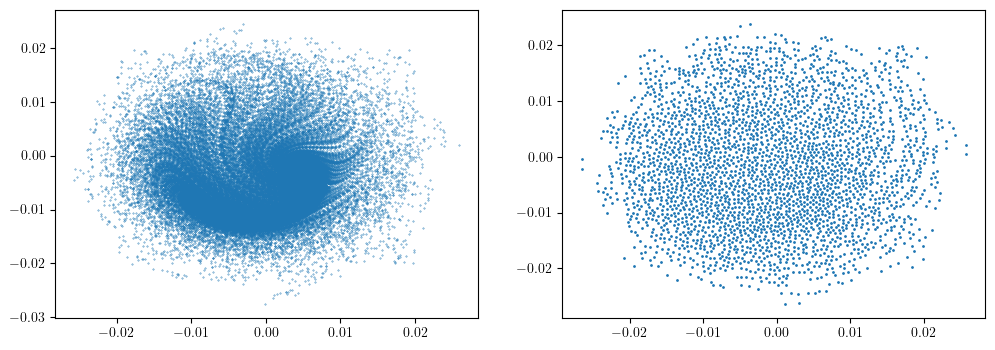

In [9]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(Xtrain_0[:,0],Xtrain_0[:,1],s=.1)
ax[1].scatter(Xtest_hat[:,0],Xtest_hat[:,1],s=1)
plt.show()

# Make torch data and set the model

In [10]:
data_train = [np.hstack([Xtrain_0,Xtrain_1]),Xtrain_hat]
data_test  = [np.hstack([Xtest_0,Xtest_1]),  Xtest_hat]

In [11]:
model_V = FCNN(input_dim=dim,output_dim=1,  num_hidden=3,hidden_dim=100,act=tanh).cuda()
model_g = FCNN(input_dim=dim,output_dim=dim,num_hidden=3,hidden_dim=100,act=tanh).cuda()
model   = SDE_model(model_V=model_V,model_g=model_g,dim=dim).cuda();
SOL     = Solver(model)

In [12]:
# set mu and sigma
model.mu.data    = torch.tensor(np.mean(data_train[0][:,:dim],axis=0)).cuda()
model.sigma.data = torch.tensor(np.std(data_train[0][:,:dim],axis=0)).cuda()

# set coef_V and coef_g
X0,X1,_ = data_train[0][:,:dim],data_train[0][:,dim:],data_train[1]
f_true  = (X1-X0)/dt
V,dV    = model.get_V_dV(X0)
g       = model.get_g(X0)
f_norm  = np.linalg.norm(f_true,axis=-1)
f_norm  = torch.tensor(f_norm).cuda()
dV_norm = torch.norm(dV,dim=-1)
g_norm  = torch.norm(g,dim=-1)
model.coef_V.data = (model.coef_V*torch.sum(dV_norm*f_norm)/torch.sum(dV_norm*dV_norm)).clone().detach()
model.coef_g.data = (model.coef_g*torch.sum(g_norm*f_norm)/torch.sum(g_norm*g_norm)).clone().detach()

print(model.mu,model.sigma,model.coef_V,model.coef_g)
torch.save(model.state_dict(), 'saved_models/B1')
torch.cuda.empty_cache()

Parameter containing:
tensor([-0.0017, -0.0067], device='cuda:0') Parameter containing:
tensor([0.0064, 0.0058], device='cuda:0') Parameter containing:
tensor(1.4306e-08, device='cuda:0') Parameter containing:
tensor(5.4696e-05, device='cuda:0')


# Set the loss

In [13]:
ini  = sample_initial(200,ll)
tmp  = perform_ode(ini,SYS.get_force,T*10,dt,m,RK4,mode="X0")

mask_A = tmp[:,-1,0]<0
mask_B = tmp[:,-1,0]>0
state_A = tmp[mask_A][:,-1][0]
state_B = tmp[mask_B][:,-1][0]
state_A,state_B

  0%|          | 0/10000 [00:00<?, ?it/s]

(array([-0.00710054, -0.01090369]), array([ 0.00410583, -0.00117451]))

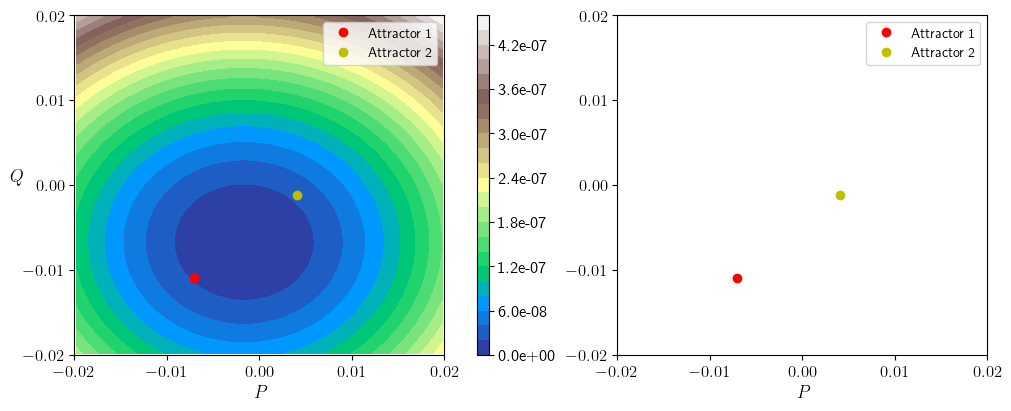

In [14]:
def get_cos_angle(dV,g,delta_2=.1):
    tmp0 = torch.sum(dV*g,axis=-1)
    tmp  = torch.sum(dV**2,axis=-1)*torch.sum(g**2,axis=-1)
    condition = torch.greater(tmp0,0)
    return torch.mean( torch.where(condition, 
                                tmp0**2/tmp, 
                        delta_2*tmp0**2/tmp) )
def get_loss(model,data,h=dt,lbd=1.):

    X0,X1,Xhat = data[0][:,:dim],data[0][:,dim:],data[1]
    X0 = torch.tensor(X0,requires_grad=True).cuda()
    X1 = torch.tensor(X1).cuda()

    _,dV = model.get_V_dV(X0)
    g    = model.get_g(X0)
    f    = -dV+g
    X1_NN = X0 + f*h/2
    
    _,dV = model.get_V_dV(X1_NN)
    g    = model.get_g(X1_NN)
    f    = -dV+g
    X1_NN = X0 + f*h
    
    diff = (X1_NN-X1)/h
    
    dyn_loss = torch.mean( torch.sum(diff**2,axis=-1) )*1e10

    V,dV = model.get_V_dV(Xhat)
    g    = model.get_g(Xhat)
    orth_loss = get_cos_angle(dV,g)
    return dyn_loss, orth_loss, dyn_loss+lbd*orth_loss    
def plot_model(model,cmap='terrain',max_V = 10):
    
    xx     = np.linspace(SYS.xrange[0],SYS.xrange[1],100)
    yy     = np.linspace(SYS.yrange[0],SYS.yrange[1],100)
    xx,yy  = (xx[:-1]+xx[1:])/2,(yy[:-1]+yy[1:])/2
    XX,YY  = np.meshgrid(xx,yy)
    X_u    = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    
    V_NN  = model.get_V_np(X_u).reshape(XX.shape)
    V_NN_min = V_NN.min()
    V_NN  = V_NN-V_NN_min

    fig, ax    = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
    c      = ax[0].contourf(XX,YY,np.minimum(V_NN,max_V),25,cmap=cmap)
    cbar   = fig.colorbar(c,ax=ax[0],format='%.1e',aspect=30)
    cbar.ax.tick_params(labelsize=12)
    
    for k in range(2):
        ax[k].set_xlim(SYS.xrange)
        ax[k].set_ylim(SYS.yrange)
        ax[k].set_xlabel(r'$P$', fontsize=13)
        if k==0: ax[k].set_ylabel(r'$Q$', fontsize=13, rotation=1)
        ax[k].plot(state_A[0],state_A[1],'ro',label='Attractor 1')
        ax[k].plot(state_B[0],state_B[1],'yo',label='Attractor 2')
        ax[k].set_xticks([-0.02,-0.01,0,0.01,0.02])
        ax[k].set_yticks([-0.02,-0.01,0,0.01,0.02])
        ax[k].legend(fontsize=10,loc='upper right')
        
    for i in range(len(ax)): 
        ax[i].tick_params(axis="both", labelsize=12)
    plt.show()
    
plot_model(model)

(1000, 100, 2) 	 9.14e-01 +- 2.19e-01 


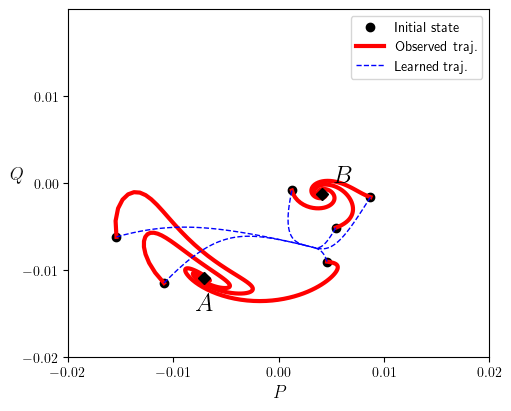

In [15]:
def rL2(x,y): 
    x = np.reshape(x,(len(x),-1))
    y = np.reshape(y,(len(y),-1))
    return np.sqrt( np.sum((x-y)**2,axis=-1).mean()/np.sum(x**2,axis=-1).mean() )

Int_Pars = {}
Int_Pars['dt'] = 10; Int_Pars['T'] = int(1e4); Int_Pars['m'] = 10; Int_Pars['integrator']=RK2;
X0 = sample_initial(1000,ll)

def Evaluate_Model(model,X0=X0,ax=None,Int_Pars=Int_Pars,get_f1=SYS.get_force,figname=None):
    def get_f2(X,model=model):
        X    = torch.tensor(X,requires_grad=True).cuda()
        _,dV = model.get_V_dV(X)
        g    = model.get_g(X)
        f    = -dV+g
        return f.cpu().data.numpy()
    dt,T,m,integrator = Int_Pars['dt'],Int_Pars['T'],Int_Pars['m'],Int_Pars['integrator']
    exact_traj   = perform_ode(X0,get_f1,T,dt,m,num_steps=5,integrator=RK4,mode='X0',use_tqdm=False)
    learned_traj = perform_ode(X0,get_f2,T,dt,m,integrator,mode='X0',use_tqdm=False)
    errors = []
    for k in range(len(exact_traj)):
        errors.append(rL2(exact_traj[k],learned_traj[k]))
    print(exact_traj.shape,'\t %.2e +- %.2e '%(np.mean(errors),np.std(errors)))
    
    if ax==None: fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=100,constrained_layout=True)
    id1 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.008,-0.001],axis=-1))
    id2 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.001,-0.001],axis=-1))
    id3 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.005,-0.005],axis=-1))
    id4 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[-0.015,-0.006],axis=-1))
    id5 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[0.005,-0.009],axis=-1))
    id6 = np.argmin(np.linalg.norm(learned_traj[:,0,:]-[-0.01,-0.0115],axis=-1))
    ax.plot(learned_traj[[id1,id2,id3,id4,id5,id6],0][:,0], learned_traj[[id1,id2,id3,id4,id5,id6],0][:,1],'ko',
            markersize=6,label='Initial state')
    for kk,k in enumerate([id1,id2,id3,id4,id5,id6]):
        
        if kk==0: label = 'Observed traj.'
        else: label = None
        ax.plot(exact_traj[k,:,0],exact_traj[k,:,1],'r-',lw=3,label=label)
        
        if kk==0: label = 'Learned traj.'
        else: label = None 
        ax.plot(learned_traj[k,:,0],learned_traj[k,:,1],'b--',lw=1,label=label)
        
    ax.set_xlim(SYS.xrange)
    ax.set_ylim(SYS.yrange)
    ax.set_xlabel(r'$P$', fontsize=13)
    ax.set_ylabel(r'$Q$', fontsize=13, rotation=1)
    ax.plot(state_A[0], state_A[1],'kD')
    ax.plot(state_B[0], state_B[1],'kD')
    ax.text(state_A[0] , state_A[1]-.003,r'$A$',fontsize=18,ha='center', va='center')
    ax.text(state_B[0]+.002,  state_B[1]+.002,r'$B$',fontsize=18,ha='center', va='center')
    ax.set_xticks([-0.02,-0.01,0,0.01,0.02])
    ax.set_yticks([-0.02,-0.01,0,0.01,])
    ax.legend(fontsize=10,loc='upper right')
    
    if figname is not None: plt.savefig(figname,dpi=300,bbox_inches='tight')
    if ax is None: plt.show()
        
Evaluate_Model(model)
torch.cuda.empty_cache()

# Train the NNs

0.1
Parameter containing:
tensor([-0.0017, -0.0067], device='cuda:0') Parameter containing:
tensor([0.0064, 0.0058], device='cuda:0') Parameter containing:
tensor(1.4306e-08, device='cuda:0') Parameter containing:
tensor(5.4696e-05, device='cuda:0')
 0k, Loss: 2.10030 0.17408, 2.05809 0.17538, 
 5k, Loss: 5.80e-03 0.01933, 5.85e-03 0.02267, 
10k, Loss: 1.59e-03 9.93e-03, 1.64e-03 0.01065, 
15k, Loss: 2.35e-04 4.53e-03, 2.60e-04 5.34e-03, 
20k, Loss: 1.60e-03 4.08e-03, 1.60e-03 5.14e-03, 
25k, Loss: 1.79e-04 3.12e-03, 2.05e-04 3.82e-03, 
30k, Loss: 4.54e-04 5.37e-03, 4.86e-04 6.52e-03, 
35k, Loss: 3.84e-03 7.95e-03, 3.88e-03 9.60e-03, 
40k, Loss: 1.11e-04 1.88e-03, 1.34e-04 3.32e-03, 
45k, Loss: 5.67e-05 1.44e-03, 7.76e-05 2.43e-03, 
50k, Loss: 4.84e-05 1.30e-03, 6.74e-05 2.10e-03, 
55k, Loss: 3.27e-05 1.22e-03, 5.07e-05 1.93e-03, 
60k, Loss: 3.23e-05 1.29e-03, 5.12e-05 1.88e-03, 
65k, Loss: 3.31e-05 1.17e-03, 5.09e-05 1.84e-03, 
70k, Loss: 4.63e-05 1.27e-03, 6.32e-05 1.86e-03, 
75k, Lo

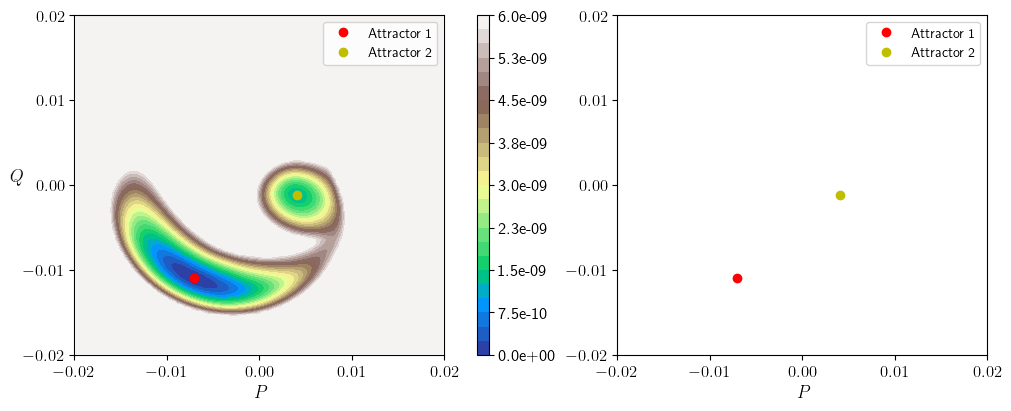

(1000, 100, 2) 	 6.23e-03 +- 1.80e-02 
0.01
Parameter containing:
tensor([-0.0017, -0.0067], device='cuda:0') Parameter containing:
tensor([0.0064, 0.0058], device='cuda:0') Parameter containing:
tensor(1.4306e-08, device='cuda:0') Parameter containing:
tensor(5.4696e-05, device='cuda:0')
 0k, Loss: 2.10030 0.17408, 2.05809 0.17538, 
 5k, Loss: 2.93e-03 0.05529, 3.06e-03 0.06501, 
10k, Loss: 9.40e-04 0.01658, 9.73e-04 0.01815, 
15k, Loss: 1.76e-04 0.02366, 2.07e-04 0.02599, 
20k, Loss: 4.94e-04 0.01004, 5.50e-04 0.01087, 
25k, Loss: 8.52e-05 9.14e-03, 1.10e-04 9.77e-03, 
30k, Loss: 8.93e-05 7.85e-03, 1.12e-04 7.83e-03, 
35k, Loss: 1.65e-05 6.03e-03, 3.50e-05 6.46e-03, 
40k, Loss: 8.86e-05 5.99e-03, 1.08e-04 6.57e-03, 
45k, Loss: 7.30e-05 5.37e-03, 9.19e-05 5.63e-03, 
50k, Loss: 1.40e-04 6.29e-03, 1.56e-04 6.38e-03, 
55k, Loss: 3.54e-05 4.18e-03, 4.99e-05 4.60e-03, 
60k, Loss: 1.66e-05 3.93e-03, 3.05e-05 4.49e-03, 
65k, Loss: 8.69e-06 3.73e-03, 2.27e-05 4.23e-03, 
70k, Loss: 1.41e-05 3.

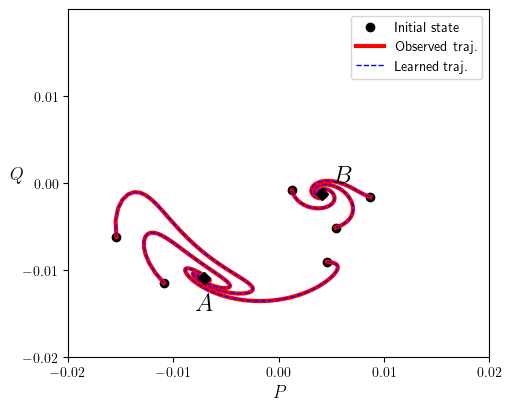

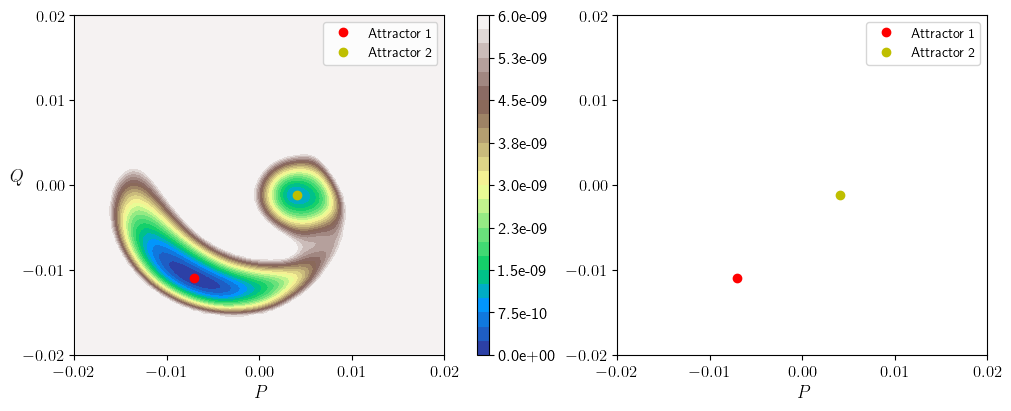

(1000, 100, 2) 	 4.10e-03 +- 1.73e-02 
0.001
Parameter containing:
tensor([-0.0017, -0.0067], device='cuda:0') Parameter containing:
tensor([0.0064, 0.0058], device='cuda:0') Parameter containing:
tensor(1.4306e-08, device='cuda:0') Parameter containing:
tensor(5.4696e-05, device='cuda:0')
 0k, Loss: 2.10030 0.17408, 2.05809 0.17538, 
 5k, Loss: 8.58e-04 0.21716, 9.66e-04 0.24785, 
10k, Loss: 1.79e-04 0.19610, 2.21e-04 0.22632, 
15k, Loss: 7.20e-04 0.15162, 7.45e-04 0.17938, 
20k, Loss: 5.85e-05 0.13777, 7.83e-05 0.16307, 
25k, Loss: 3.87e-04 0.12166, 3.98e-04 0.14566, 
35k, Loss: 8.79e-05 0.07024, 9.97e-05 0.08513, 
40k, Loss: 2.75e-04 0.04125, 2.82e-04 0.04865, 
45k, Loss: 1.99e-05 0.03004, 3.04e-05 0.03399, 
50k, Loss: 1.68e-05 0.02585, 2.80e-05 0.02959, 
55k, Loss: 4.48e-06 0.02039, 1.51e-05 0.02306, 
60k, Loss: 1.78e-05 0.01763, 2.85e-05 0.01923, 
65k, Loss: 9.72e-06 0.01566, 1.98e-05 0.01684, 
70k, Loss: 5.66e-06 0.01392, 1.64e-05 0.01517, 
75k, Loss: 1.87e-06 0.01301, 1.27e-05 0

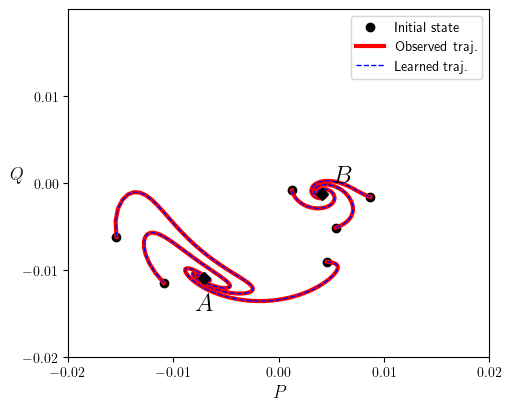

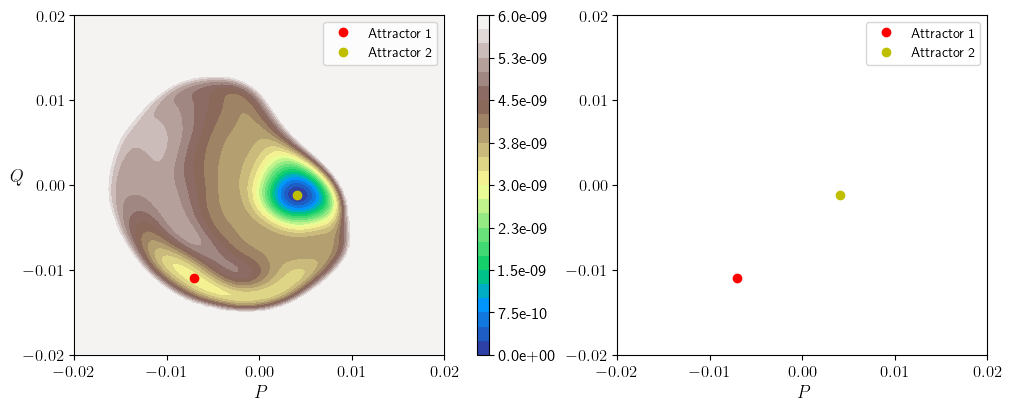

(1000, 100, 2) 	 1.84e-03 +- 4.80e-03 


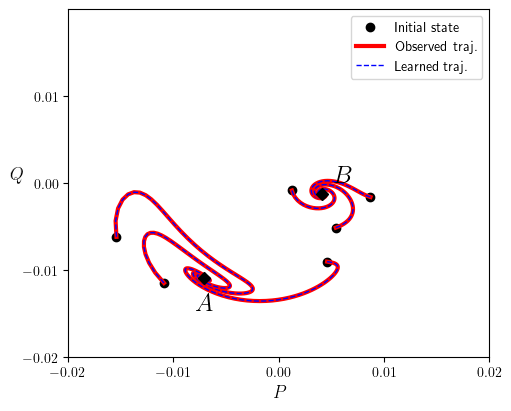

In [18]:
for lbd in [.1,.01,1e-3]:
    print(lbd)
    get_loss.__defaults__ = (get_loss.__defaults__[0],lbd);
    model.load_state_dict(torch.load("saved_models/B1"))
    print(model.mu,model.sigma,model.coef_V,model.coef_g)
    optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(5e-3).cuda())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95**(1/1000))
    _loss_step = SOL.train_model(data_train=data_train,data_test=data_test,
                                 get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                                 n_steps=int(1.5e5+1),batch_size=5000,n_show_loss=5000,use_tqdm=False)

    torch.save(model.state_dict(), "saved_models/model_ex22_"+str(lbd))
    plot_model(model,max_V=6e-9)
    Evaluate_Model(model)
    torch.cuda.empty_cache()

In [19]:
torch.save([data_train,data_test,X0X1],'data_2')